In [113]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential, load_model
from keras.callbacks import CSVLogger, ReduceLROnPlateau
from keras.optimizers import adam_v2
import transbigdata as tbd
import warnings


In [114]:
warnings.filterwarnings("ignore")
np.random.seed(120)
tf.random.set_seed(120)
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [115]:
def hav(theta):
    s = np.sin(theta / 2)
    return s * s

def get_distance_hav(lat0, lng0, lat1, lng1):
    EARTH_RADIUS = 6371
    lat0 = np.radians(lat0)
    lat1 = np.radians(lat1)
    lng0 = np.radians(lng0)
    lng1 = np.radians(lng1)

    dlng = np.fabs(lng0 - lng1)
    dlat = np.fabs(lat0 - lat1)
    h = hav(dlat) + np.cos(lat0) * np.cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(h))
    return distance

def createSequence(data, window=10, maxmin=None):
    train_seq = []
    train_label = []
    m, n = maxmin
    for traj_id in set(data['mmsi']):
        data_temp = data.loc[data.mmsi == traj_id]
        first_lon = data_temp.loc[0, 'lon']
        first_lat = data_temp.loc[0, 'lat']
        end_lon = data_temp.loc[data_temp.shape[0] - 1, 'lon']
        end_lat = data_temp.loc[data_temp.shape[0] - 1, 'lat']

        data_temp = np.array(data_temp.loc[:, ['lon', 'lat', 'sog', 'cog']])
        # 标准化
        data_temp = (data_temp - n) / (m - n)

        for i in range(data_temp.shape[0] - window):
            x = []
            for j in range(i, i + window):
                x.append(list(data_temp[j, :]))
            train_seq.append(x)
            train_label.append(data_temp[i + window, :])

    train_seq = np.array(train_seq, dtype='float64')
    train_label = np.array(train_label, dtype='float64')

    return train_seq, train_label

# 多维反归一化
def FNormalizeMult(y_pre, y_true, max_min):
    [m1, n1, s1, c1], [m2, n2, s2, c2] = max_min
    y_pre[:, 0] = y_pre[:, 0] * (m1 - m2) + m2
    y_pre[:, 1] = y_pre[:, 1] * (n1 - n2) + n2
    y_pre[:, 2] = y_pre[:, 2] * (s1 - s2) + s2
    y_pre[:, 3] = y_pre[:, 3] * (c1 - c2) + c2
    y_true[:, 0] = y_true[:, 0] * (m1 - m2) + m2
    y_true[:, 1] = y_true[:, 1] * (n1 - n2) + n2
    y_true[:, 2] = y_true[:, 2] * (s1 - s2) + s2
    y_true[:, 3] = y_true[:, 3] * (c1 - c2) + c2

    # 计算距离
    y_pre = np.insert(y_pre, y_pre.shape[1],
                      get_distance_hav(y_true[:, 1], y_true[:, 0], y_pre[:, 1], y_pre[:, 0]), axis=1)

    return y_pre, y_true

In [116]:
# def trainModel(train_X, train_Y, test_X, test_Y):
#     model = Sequential()
#     model.add(LSTM(108, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
#     # model.add(Dropout(0.3))
#     model.add(Dense(train_Y.shape[1]))
#     model.add(Activation("relu"))
#     adam = adam_v2.Adam(learning_rate=0.01)
#     model.compile(loss='mse', optimizer=adam, metrics=['acc'])
#     log = CSVLogger(f"./log.csv", separator=",", append=True)
#     reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=1, verbose=1,
#                                mode='auto', min_delta=0.001, cooldown=0, min_lr=0.001)

#     model.fit(train_X, train_Y, epochs=20, batch_size=32, verbose=1, validation_split=0.1,
#                   callbacks=[log, reduce])
#     loss, acc = model.evaluate(test_X, test_Y, verbose=1)
#     print('Loss : {}, Accuracy: {}'.format(loss, acc * 100))
#     model.save(f"./model.h5")
#     # 打印神经网络结构，统计参数数目
#     model.summary()
#     return model

In [117]:
from keras.layers import GRU

def trainModel(train_X, train_Y, test_X, test_Y):
    model = Sequential()
    model.add(GRU(108, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
    # model.add(Dropout(0.3))
    model.add(Dense(train_Y.shape[1]))
    model.add(Activation("relu"))
    adam = adam_v2.Adam(learning_rate=0.01)
    model.compile(loss='mse', optimizer=adam, metrics=['acc'])
    # 保存训练过程中损失函数和精确度的变化
    log = CSVLogger(f"./log50炼丹3.csv", separator=",", append=True)
    # 用来自动降低学习率
    reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=1, verbose=1,
                               mode='auto', min_delta=0.001, cooldown=0, min_lr=0.001)
	# 模型训练
    model.fit(train_X, train_Y, epochs=50, batch_size=32, verbose=1, validation_split=0.1,
                  callbacks=[log, reduce])
    # 用测试集评估
    loss, acc = model.evaluate(test_X, test_Y, verbose=1)
    print('Loss : {}, Accuracy: {}'.format(loss, acc * 100))
    # 保存模型
    model.save(f"./GRU_50_model炼丹3_.h5")
    # 打印神经网络结构，统计参数数目
    model.summary()
    return model

# 使用训练数据集和测试数据集训练GRU模型
# model = trainModel(train_X, train_Y, test_X, test_Y)


In [118]:
# 获取数据
train = pd.read_csv("./train.csv",index_col=0)
test = pd.read_csv("./test.csv",index_col=0)
train.head()

mmsi     updateDateFormat         lon  \
0  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:41:01  120.468625   
1  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:43:01  120.466964   
2  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:45:01  120.465346   
3  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:47:01  120.463671   
4  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:49:01  120.461955   

         lat  cog  sog  
0  30.736513  264  1.7  
1  30.736357  258  1.7  
2  30.736038  258  1.8  
3  30.735686  259  1.8  
4  30.735358  261  1.9

In [119]:
# 计算归一化参数
nor = np.array(train.loc[:, ['lon', 'lat', 'sog', 'cog']])
m = nor.max(axis=0)
n = nor.min(axis=0)
maxmin = [m, n]
# 步长
windows = 10
train_seq, train_label = createSequence(train, windows, maxmin)
test_seq, test_label = createSequence(test, windows, maxmin)

In [120]:
# 训练模型
model = trainModel(train_seq, train_label,test_seq,test_label)
# model = load_model("./model.h5")

Epoch 1/50
3282/3282 [==============================] - 53s 16ms/step - loss: 0.0035 - acc: 0.9096 - val_loss: 0.0023 - val_acc: 0.9323 - lr: 0.0100
Epoch 2/50
3282/3282 [==============================] - 51s 15ms/step - loss: 0.0022 - acc: 0.9275 - val_loss: 0.0018 - val_acc: 0.9365 - lr: 0.0100
Epoch 3/50
3282/3282 [==============================] - 51s 15ms/step - loss: 0.0020 - acc: 0.9370 - val_loss: 0.0016 - val_acc: 0.9485 - lr: 0.0100
Epoch 4/50
3282/3282 [==============================] - 51s 16ms/step - loss: 0.0019 - acc: 0.9425 - val_loss: 0.0017 - val_acc: 0.9548 - lr: 0.0100
Epoch 5/50
3280/3282 [============================>.] - ETA: 0s - loss: 0.0017 - acc: 0.9480
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
3282/3282 [==============================] - 51s 16ms/step - loss: 0.0017 - acc: 0.9480 - val_loss: 0.0020 - val_acc: 0.9438 - lr: 0.0100
Epoch 6/50
3279/3282 [============================>.] - ETA: 0s - loss: 0.0015 - acc: 0.9550
Epoch

394/394 [==============================] - 1s 4ms/step - loss: 0.0013 - acc: 0.9693
Loss : 0.0013159170048311353, Accuracy: 96.9275951385498
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 108)               36936     
                                                                 
 dense_7 (Dense)             (None, 4)                 436       
                                                                 
 activation_7 (Activation)   (None, 4)                 0         
                                                                 
Total params: 37,372
Trainable params: 37,372
Non-trainable params: 0
_________________________________________________________________


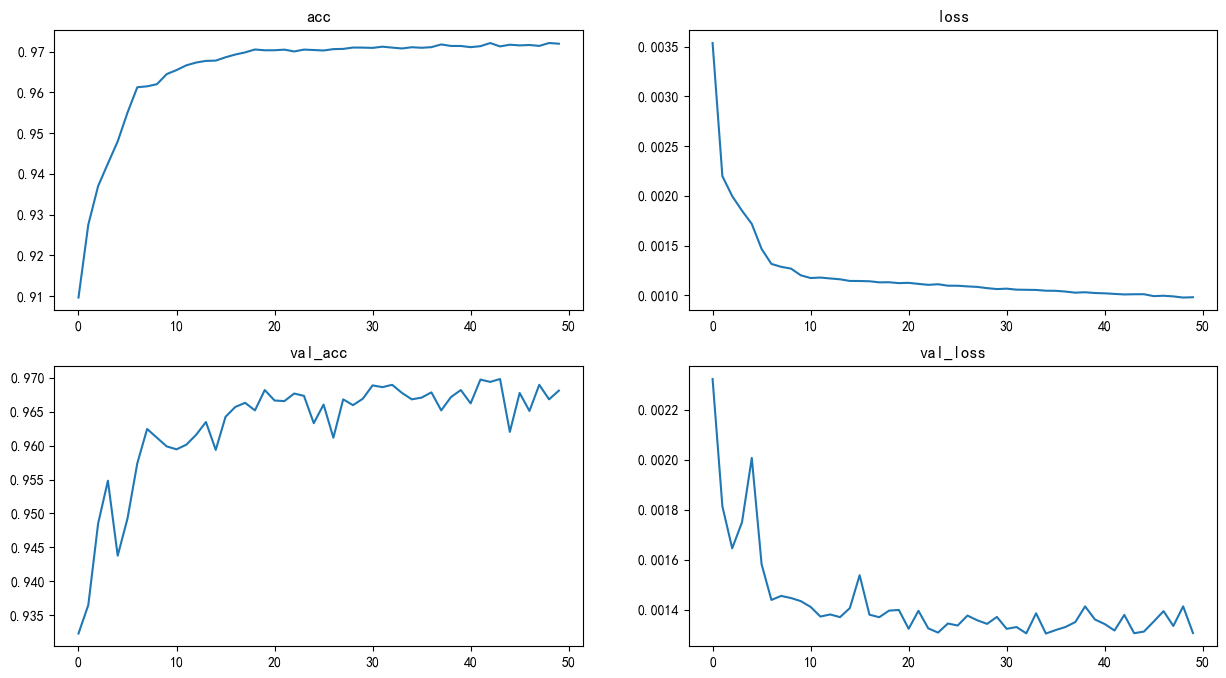

In [121]:
logs = pd.read_csv("./log50炼丹3.csv")

fig, ax = plt.subplots(2,2,figsize=(15,8))
ax[0][0].plot(logs['epoch'],logs['acc'], label='acc')
ax[0][0].set_title('acc')

ax[0][1].plot(logs['epoch'],logs['loss'], label='loss')
ax[0][1].set_title('loss')

ax[1][0].plot(logs['epoch'],logs['val_acc'], label='val_acc')
ax[1][0].set_title('val_acc')

ax[1][1].plot(logs['epoch'],logs['val_loss'], label='val_loss')
ax[1][1].set_title('val_loss')

plt.show()

1/1 [==============================] - 0s 14ms/step
最大值: 0.05502304324384272
最小值: 0.0033273353315749804
均值: 0.021532041503991076
方差: 0.0001373213213177191
标准差: 0.01171841803818754
中位数: 0.02053275889168802


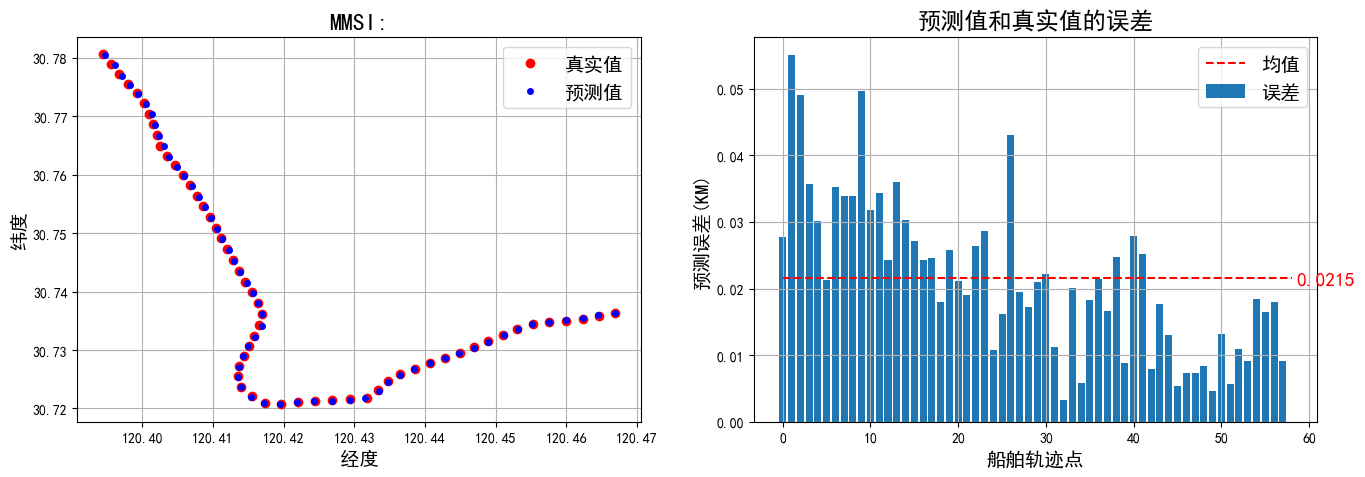

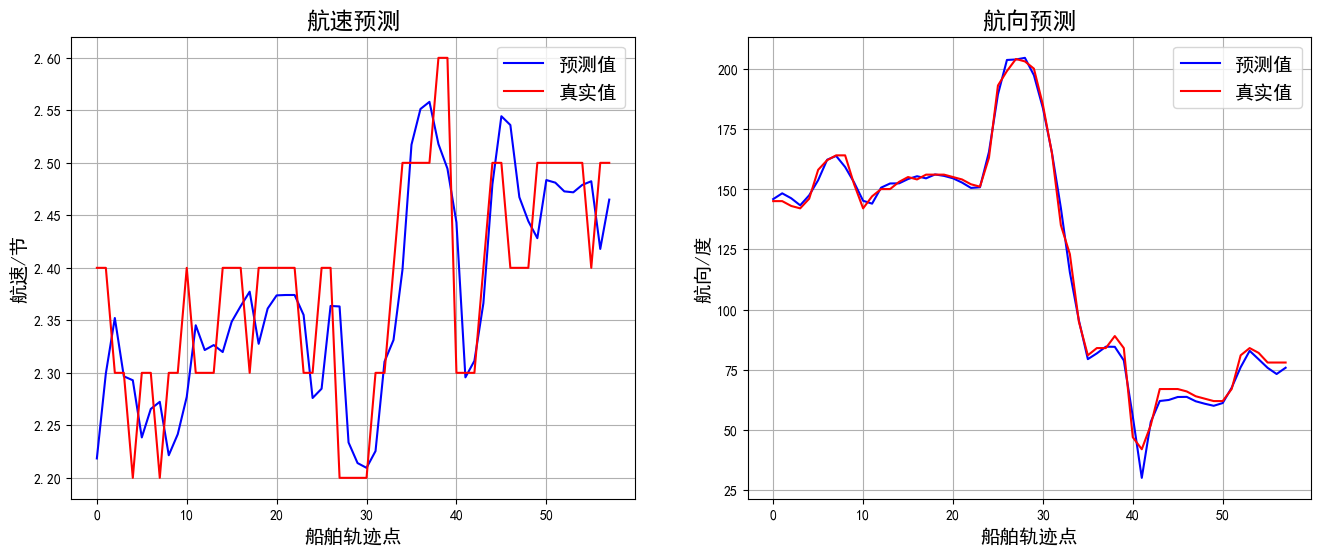

In [122]:
test_points_ids = list(set(test['mmsi']))

for ids in test_points_ids[:1]:
    y_pre = []
    test_seq, test_label = createSequence(test.loc[test.mmsi == ids], windows, maxmin)

    y_true = test_label
    for i in range(len(test_seq)):
        y_hat = model.predict(test_seq[i].reshape(1, windows, 4))
        y_pre.append(y_hat[0])
    y_pre = np.array(y_pre, dtype='float64')

    f_y_pre, f_y_true = FNormalizeMult(y_pre, y_true, maxmin)

    print(f"最大值: {max(f_y_pre[:, 4])}\n最小值: {min(f_y_pre[:, 4])}\n均值: {np.mean(f_y_pre[:, 4])}\n"
          f"方差: {np.var(f_y_pre[:, 4])}\n标准差: {np.std(f_y_pre[:, 4])}\n中位数: {np.median(f_y_pre[:, 4])}")

    # 画测试样本数据库
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.plot(f_y_true[:, 0], f_y_true[:, 1], "ro", markersize=6,label='真实值')
    plt.plot(f_y_pre[:, 0], f_y_pre[:, 1], "bo",markersize=4, label='预测值')
#     bounds = [min(f_y_true[:, 0])-0.02,min(f_y_true[:, 1])-0.01,max(f_y_true[:, 0])+0.02,max(f_y_true[:, 1])+0.01]
#     tbd.plot_map(plt,bounds,zoom = 16,style = 3)
    plt.legend(fontsize=14)
    plt.grid()
    plt.xlabel("经度",fontsize=14)
    plt.ylabel("纬度",fontsize=14)
    plt.title("MMSI:",fontsize=17)

    meanss = np.mean(f_y_pre[:, 4])
    plt.subplot(122)
    plt.bar(range(f_y_pre.shape[0]),f_y_pre[:, 4],label='误差')
    plt.plot([0,f_y_pre.shape[0]],[meanss,meanss],'--r',label="均值")
    plt.title("预测值和真实值的误差",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("预测误差(KM)",fontsize=14)
    plt.text(f_y_pre.shape[0]*1.01,meanss*0.96,round(meanss,4),fontsize=14,color='r')
    plt.grid()
    plt.legend(fontsize=14)

    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(f_y_pre[:, 2], "b-", label='预测值')
    plt.plot(f_y_true[:, 2], "r-", label='真实值')
    plt.legend(fontsize=14)
    plt.title("航速预测",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("航速/节",fontsize=14)
    plt.grid()

    plt.subplot(122)
    plt.plot(f_y_pre[:, 3], "b-", label='预测值')
    plt.plot(f_y_true[:, 3], "r-", label='真实值')
    plt.legend(fontsize=14)
    plt.title("航向预测",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("航向/度",fontsize=14)
    plt.grid()

1/1 [==============================] - 0s 15ms/step


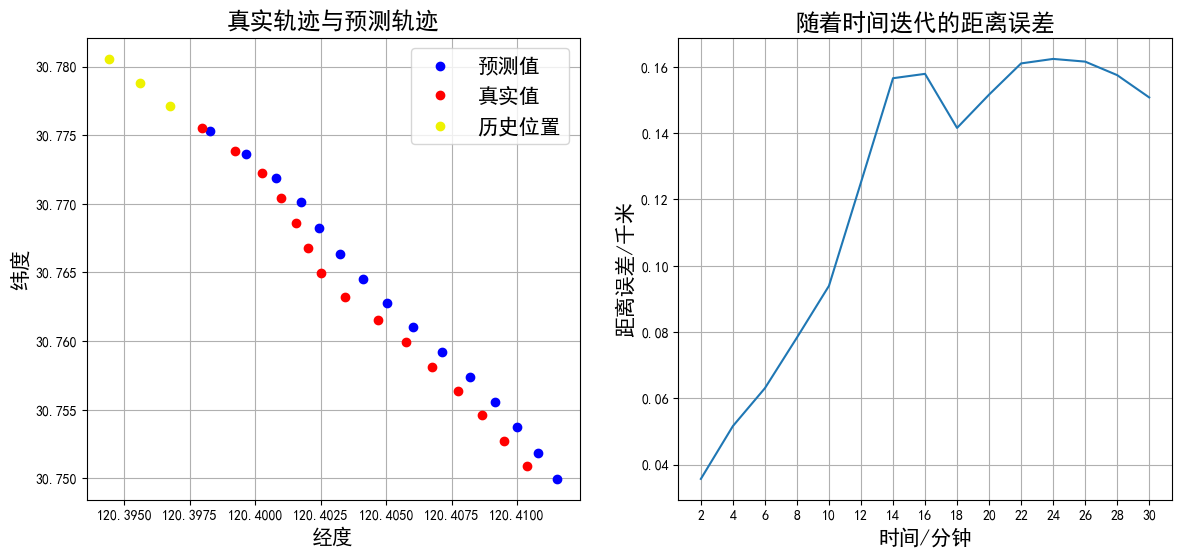

In [123]:
for ids in test_points_ids[:1]:
    test_seq, test_label = createSequence(test.loc[test.mmsi == ids], windows,maxmin)

    y_pre = []
    for i in range(len(test_seq)):
        y_hat = model.predict(test_seq[i].reshape(1, windows, 4))
        y_pre.append(y_hat[0])
    y_pre = np.array(y_pre, dtype='float64')
    # 得到真实值
    _,true_lables = FNormalizeMult(y_pre,np.copy(test_label),maxmin)

    for start_id in range(3,4):
        # 单值预测
        y_pre=[]
        y_true = []
        pre_seq = test_seq[start_id]
        maxStep = min(15,test_seq.shape[0] - start_id)
        # 循环预测
        for i in range(maxStep):
            y_hat = model.predict(pre_seq.reshape(1, windows, 4))
            y_pre.append(y_hat[0])
            y_true.append(test_label[start_id+i])
            # 下一个数组
            pre_seq = np.insert(pre_seq, pre_seq.shape[0], y_pre[i], axis=0)[1:]

        y_pre = np.array(y_pre, dtype='float64')
        y_true = np.array(y_true, dtype='float64')
        f_y_pre,f_y_true = FNormalizeMult(y_pre,y_true,maxmin)

        plt.figure(figsize=(14,6))
        plt.subplot(121)
        plt.plot(f_y_pre[:, 0], f_y_pre[:, 1], "bo", label='预测值')
        plt.plot(f_y_true[:, 0], f_y_true[:, 1], "ro", label='真实值')
        plt.plot(true_lables[:start_id, 0], true_lables[:start_id, 1], "o",color='#eef200', label='历史位置')
#         bounds = [min(f_y_true[:, 0])-0.01,min(f_y_true[:, 1])-0.01,max(f_y_true[:, 0])+0.01,max(f_y_true[:, 1])+0.01]
#         tbd.plot_map(plt,bounds,zoom = 16,style = 3)
        plt.legend(fontsize=15)
        plt.title(f'预测步数量={maxStep},开始位置={start_id}',fontsize=17)
        plt.title(f'真实轨迹与预测轨迹',fontsize=17)
        plt.xlabel("经度",fontsize=15)
        plt.ylabel("纬度",fontsize=15)
        plt.grid()

        plt.subplot(122)
        plt.plot(np.arange(2,2*(maxStep)+1,2),f_y_pre[:,4])
        plt.xticks(np.arange(2,2*(maxStep)+1,2))
        plt.title(f'随着时间迭代的距离误差',fontsize=17)
        plt.xlabel("时间/分钟",fontsize=15)
        plt.ylabel("距离误差/千米",fontsize=15)
        plt.grid()

In [124]:
error_list = []
for ids in test_points_ids[:1]:
    test_seq, test_label = createSequence(test.loc[test.mmsi == ids], windows, maxmin)
    # 要预测的时间
    pre_time = 60
    for start_id in range(test_seq.shape[0]-int(pre_time/2)):
        # 单值预测
        y_pre=[]
        y_true = []
        pre_seq = test_seq[start_id]
        # 循环预测
        for i in range(int(pre_time/2)):
            y_hat = model.predict(pre_seq.reshape(1, windows, 4))
            y_pre.append(y_hat[0])
            y_true.append(test_label[start_id+i])
            # 下一个数组，把预测的值作为预测序列的最后一个值，实现循环预测
            pre_seq = np.insert(pre_seq, pre_seq.shape[0], y_pre[i], axis=0)[1:]

        y_pre = np.array(y_pre, dtype='float64')
        y_true = np.array(y_true, dtype='float64')
        f_y_pre,f_y_true = FNormalizeMult(y_pre,y_true,maxmin)
        error_list.append(list(f_y_pre[:,4]))

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


Text(0.5, 1.0, '整条轨迹上随时间变化的预测距离误差')

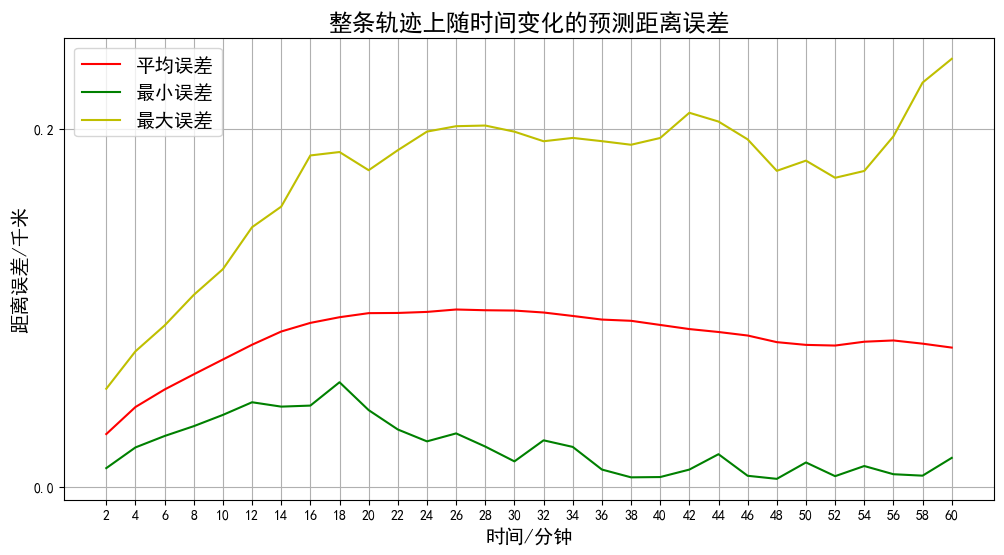

In [125]:
b = np.zeros([len(error_list),len(max(error_list,key = lambda x: len(x)))])
for i,j in enumerate(error_list):
    b[i][0:len(j)] = j

sums = b.sum(axis=0)
maxx = b.max(axis=0)
minx = []
means = []
for col in range(b.shape[1]):
    fzeros = b.shape[0] - list(b[:,col]).count(0.0)
    minx.append(min(list(b[:fzeros,col])))
    means.append(sums[col] / fzeros)

plt.figure(figsize=(12,6))
plt.plot(np.arange(2,2*(b.shape[1])+1,2),means,'-r',label='平均误差')
plt.plot(np.arange(2,2*(b.shape[1])+1,2),minx,'-g',label='最小误差')
plt.plot(np.arange(2,2*(b.shape[1])+1,2),maxx,'-y',label='最大误差')
plt.xticks(np.arange(2,2*(b.shape[1])+1,2))
plt.yticks(np.arange(0,max(maxx),0.2))
plt.xlabel("时间/分钟",fontsize=14)
plt.ylabel("距离误差/千米",fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.title("整条轨迹上随时间变化的预测距离误差",fontsize=17)

In [126]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(f_y_true[:, 1], f_y_pre[:, 1])
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(f_y_true[:, 1], f_y_pre[:, 1])
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(f_y_true[:, 1], f_y_pre[:, 1])
print(f"R2分数（R2_score）: {r2}")

平均绝对误差（MAE）: 0.00038708073887706954
均方根误差（RMSE）: 0.00045899792180991274
R2分数（R2_score）: 0.9917620190477336


In [127]:
print(means)

[0.029735395660069077, 0.04481631933058483, 0.054600635892767216, 0.06305699837346776, 0.0713335674800664, 0.0795703096273815, 0.08693974561073521, 0.09175310590848447, 0.09491685403181911, 0.09718714910565089, 0.09729376546929322, 0.09788063258195022, 0.09922238826679776, 0.09880366645150504, 0.09863233388664285, 0.09754270747345886, 0.09561813555681149, 0.09360437342315342, 0.09291666945682424, 0.09060741278247268, 0.08830564514437171, 0.0866708096061078, 0.0847093805122749, 0.08101260780059753, 0.07948462279084752, 0.07911231635657527, 0.08125271102416956, 0.08195449864124797, 0.0801675823759648, 0.07797575834957686]
